# Analysis of the Jet Grouting data and proposal of prediction model

### What is Jet Grouting?

According to Ochmański et al. (2015):
    *The jet grouting is one of the most popular ground improvement methods, being adopted worldwide for the solution of various geotechnical problems (foundation, earth retaining, waterproofing etc.). The technique basically consists in cutting and mixing in place the soil with cement grout, ejected with high speed from small nozzles, in order to form sub-cylindrical columns of cemented material (Yahiro and Yoshida, 1973). Possible alternatives to the basic solution (named “single fluid” system), where only cement grout is injected, consist in protecting the action of the injected grout with a coaxial jet of air (“double fluid” system) or in using a coaxial jet of air and water to initially cut the soil and a second jet of grout to infer cementation (“triple fluid” system) (Croce et al., 2014).*

### What is a goal of this analysis?

The purpose of this study is to create and possibly improve (ref. Ochmański et al., 2015) ML model for prediction of jet grouting columns diameter. The importance of this study is of high interest for engineers as available analytical methods results in underestimation of column diameters (especially in "double fluid" system) which leads to overconservative design.

### Description of database
Database was created from quite poor experimental data. It consists of 5 features: $N_{SPT}$, energy, soil type, fluid system, $c/w$ (cement/water ratio), grout density, grout velocity and column diameter.
There are several weak points of this database:
* $N_{SPT}$ presents a mean number of blows in Standard Penetration Test (SPT) through whole soil profile (which can have several meters of thickness). Usually, this number is very variable and definetly not constant with depth, in fact it increases when going deeper.
* Diameter of the column is measured near the ground surface and it can also vary with a depth.
* Energy is calculated using analytical equation and it's not possible to back-analysed used variables.


### Literature
Croce P., Flora A., Modoni G. (2014). *Jet Grouting: Technology, Design and Control.* Taylor & Francis Group, London, 2014.

Ochmański M., Modoni G., Bzówka J. (2015). *Prediction of the diameter of jet grouting columns with artificial neural networks.* Soils and Foundations, 55(2), pp. 425-436. https://doi.org/10.1016/j.sandf.2015.02.016

Yahiro T., Yoshida H. (1973). *Induction grouting method utilizing high-speed water jet.* In: Proceedings of the Eighth ICSMFE, June 1973, Moscor, Russia, pp. 402-404.

# Table of Content

* [Initial setup](#section_1)
    * [Import packages](#section_1_1)
    * [Define functions](#section_1_2)
    * [Load data](#section_1_3)
* [Exploratory data analysis (EDA)](#section_2)
    * [Basic data description](#section_2_1)
    * [Univariate analysis](#section_2_2)
        * [Features distribution characteristics](#section_2_2_1)
        * [Transform to Gaussian distribution](#section_2_2_2)
        * [Treating categorical data](#section_2_2_3)
        * [Treating missing data](#section_2_2_4)
        * [Treating outliers](#section_2_2_5)
    * [Multivariate analysis](#section_2_3)
        * [Features correlation heatmap](#section_2_3_1)
        * [Correlation of Energy and Nspt to Diameter](#section_2_3_1)
* [Prediction model](#section_3)
* [TODO](#section_4)




# Initial setup <a class="anchor" id="section_1"></a>

## Import packages <a class="anchor" id="section_1_1"></a>

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import scipy.stats as st
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from mlxtend.plotting import scatterplotmatrix

from scipy.stats import boxcox
from scipy.stats import chisquare
from scipy import stats
from sklearn.preprocessing import QuantileTransformer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn import linear_model

from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import anderson

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

## Define functions used in the analysis <a class="anchor" id="section_1_2"></a>

In this section following functions have been defined:
1. plot_features(...) - function for univariate plots 
2. test_normality(...) - testing normality using 3 different approaches
3. transform(...) - transformation of non-Gaussian distribution to Gaussian distribution
4. data_imputation(...) - imputation for missing data using 5 different approaches: mean, median, most frequent, KNN, MICE
5. outliers(...) - detection and threatening outliers
6. binary_flag(...) - binary flag for imputed/change data

In [3]:
def plot_features(data: pd.DataFrame, features: list[str], hue: bool = True, categorical: bool = False) -> None:
    columns = max([len(features),2])
    
    if categorical:
        fig, axes = plt.subplots(1, columns+1, sharex=False, figsize=(15, 5))
        for idx, feat in enumerate(features):
            sns.countplot(data=data, ax=axes[idx], x =feat)
            axes[idx].set(xlabel='')

        sns.countplot(data=data, ax=axes[columns], x =feat, hue=features[0])

    else:
        if hue:
            fig, axes = plt.subplots(4, columns, sharex=False, figsize=(14, 8), gridspec_kw={'height_ratios':[0.1, 0.4, 0.4, 0.4]})
        else:
            fig, axes = plt.subplots(2, columns, sharex=False, figsize=(14, 4), gridspec_kw={'height_ratios':[0.1, 0.4]})
        for idx, feat in enumerate(features):
            sns.boxplot(data=data, x=feat, ax=axes[0,idx])
            sns.histplot(data=data, x=feat, ax=axes[1,idx], kde=True)
            if hue:
                sns.histplot(data=data, x=feat, ax=axes[2,idx], kde=True, hue='Soil_type')
                sns.histplot(data=data, x=feat, ax=axes[3,idx], kde=True, hue='Fluid_system')

        axes[0,idx].set(xlabel='')
        axes[0,idx].xaxis.set_visible(False)
        if hue:
            axes[1,idx].xaxis.set_visible(False)
            axes[2,idx].xaxis.set_visible(False)
    
    return None


def test_normality(data: pd.DataFrame, p_value: float = 0.05) -> bool:

    normality = []

    # The Shapiro-Wilk test 
    stat, p = shapiro(data)
    print('The Shapiro-Wilk test: ', end='')
    print(f'statistics={stat:.3f}, p={p:.5f}')
    if p > p_value:
        normality.append(True)
    else:
        normality.append(False)

    # The D’Agostino’s K^2 test
    stat, p = normaltest(data)
    print('The D\'Agostino\'s K^2 test: ', end='')
    print(f'statistics={stat:.3f}, p={p:.5f}')
    if p > p_value:
        normality.append(True)
    else:
        normality.append(False)

    # Anderson-Darling Test
    result = anderson(data, dist='norm')   
    print('The Anderson-Darling test: ', end='')
    print(f'Statistic: {result.statistic:.3f}')
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print(f'{sl:.3f}: {cv:.3f}, data looks normal (fail to reject H0)')
        else:
            print(f'{sl:.3f}: {cv:.3f}, data does not look normal (reject H0)')

    if all(i > result.statistic for i in result.critical_values):
        normality.append(True)
    else:
        normality.append(False)

    # Generate bool output
    if False in normality:
        return False
    else:
        return True


def transform(data: pd.DataFrame, feature: str, method: str = 'box-cox', normalize: bool = True) -> pd.DataFrame:

    data_np = np.array(data[feature]).reshape(-1, 1)

    if method == 'box-cox':
        scaler = PowerTransformer(method="box-cox").fit(data_np)
        data_tr = scaler.transform(data_np)
        # boxcox(data['Nspt'], 0.0)
        
    if method == 'yeo-johnson':
        scaler = PowerTransformer(method='yeo-johnson').fit(data_np)
        data_tr = scaler.transform(data_np)
    
    if method == 'quantile':
        scaler = QuantileTransformer(output_distribution='normal', n_quantiles=len(data_np)).fit(data_np)
        data_tr = scaler.transform(data_np)

    if normalize:
        scaler = MinMaxScaler().fit(data_tr)
        data_tr = scaler.transform(data_tr)

    df = pd.DataFrame(data_tr)
    df.rename(columns={0: f'trf_{feature}'}, inplace=True)

    return df


def data_imputation(data: pd.DataFrame, method: str = 'mice') -> pd.DataFrame:
    if method == 'mean':
        # replace missing with mean value
        imputer = SimpleImputer(strategy='mean')
    if method == 'median':
        # replace missing with median value
        imputer = SimpleImputer(strategy='median')
    if method == 'mode':
        # replace missing with most frequent value
        imputer = SimpleImputer(strategy='most_frequent')
    if method == 'knn':
        # replace missing with nearest neighbors imputation (KNN)
        imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
    if method == 'mice':
        # replace missing with MICE imputer
        imputer = IterativeImputer(max_iter=10, estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
    
    result = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
    return result


def outliers(data: pd.DataFrame, feature: str, detect_method: str ='IQR', threat_method: str = 'delete') -> list:
    
    if detect_method == 'Percentile':
        # Percentile method
        lower_quantile = 0.005
        upper_quantile = 0.98
        lower_limit = data[feature].quantile(lower_quantile)
        upper_limit = data[feature].quantile(upper_quantile)
    
    if detect_method == 'IQR':
        # IQR method
        Q3 = data[feature].quantile(0.75)
        Q1 = data[feature].quantile(0.25)
        IQR = Q3-Q1
        lower_limit = Q1-(1.5*IQR)
        upper_limit = Q3+(1.5*IQR)

    if threat_method == 'delete':
        # delete data entries for outliers
        return data[(data[feature] > lower_limit) & (data[feature] < upper_limit)]
    
    if threat_method == 'winsorize':
        # assign min/max for outlier
        changed_ids = []
        changed_ids.append(data.index[data[feature] < lower_limit].tolist())
        changed_ids.append(data.index[data[feature] > upper_limit].tolist())
        changed_ids = [val for sublist in changed_ids for val in sublist]

        data.loc[data[feature] < lower_limit, feature] = lower_limit
        data.loc[data[feature] > upper_limit, feature] = upper_limit

        return changed_ids


def binary_flag(data: pd.DataFrame, ids: list, feature: str, prefix: str = 'imp') -> None:

    col_name = f"{prefix}_{feature}"
    data[col_name] = 0
    data.loc[ids, col_name] = 1

    return None


## Load data <a class="anchor" id="section_1_3"></a>

Databse containing information on Jet Grouting columns and threatment parameters with the measured diameter is stored in csv file with a comma delimiter.

In [5]:
data = pd.read_csv('./JG_database_17.03.2023.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Soil_type        248 non-null    object 
 1   Nspt             248 non-null    int64  
 2   Fluid_system     248 non-null    object 
 3   c/w              248 non-null    float64
 4   grout_density    248 non-null    int64  
 5   grout_viscosity  248 non-null    float64
 6   Energy           248 non-null    float64
 7   Diameter         248 non-null    float64
dtypes: float64(4), int64(2), object(2)
memory usage: 15.6+ KB


# Exploratory Data Analysis (EDA) <a class="anchor" id="section_2"></a>
## Basic data description <a class="anchor" id="section_2_1"></a>

After ploting basic information about the database, it can be noticed that there are 2 non-ordinal categorical and 6 numerical features. Categorical features named "Soil_type" and "Fluid_system" are converted from 'object' dtype to 'category'. This in fact saves memory which is crucial in large databases.

In [7]:
data.info()

# Convert object type to category type 
data["Soil_type"] = data["Soil_type"].astype("category")
data["Fluid_system"] = data["Fluid_system"].astype("category")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Soil_type        248 non-null    category
 1   Nspt             248 non-null    int64   
 2   Fluid_system     248 non-null    category
 3   c/w              248 non-null    float64 
 4   grout_density    248 non-null    int64   
 5   grout_viscosity  248 non-null    float64 
 6   Energy           248 non-null    float64 
 7   Diameter         248 non-null    float64 
dtypes: category(2), float64(4), int64(2)
memory usage: 12.5 KB


In [8]:
# Present statisitcal summmary of the data
display(data.describe(include='all'))

,Soil_type,Nspt,Fluid_system,c/w,grout_density,grout_viscosity,Energy,Diameter
count,248,248.000000,248,248.000000,248.000000,248.000000,248.000000,248.000000
unique,3,NaN,3,NaN,NaN,NaN,NaN,NaN
top,Coarse with fine,NaN,S,NaN,NaN,NaN,NaN,NaN
freq,92,NaN,101,NaN,NaN,NaN,NaN,NaN
mean,NaN,12.274194,NaN,0.984758,1489.629032,10.506452,44.946895,1.483790
std,NaN,8.319859,NaN,0.233163,88.295003,10.144736,64.284907,0.791126
min,NaN,1.000000,NaN,0.000000,1000.000000,1.000000,3.390000,0.380000
25%,NaN,5.000000,NaN,1.000000,1500.000000,9.500000,13.500000,0.950000
50%,NaN,10.000000,NaN,1.000000,1500.000000,9.500000,24.800000,1.350000
75%,NaN,15.000000,NaN,1.000000,1500.000000,9.500000,61.010000,1.800000


In [9]:
# Show first and last 10 entries
display(data.head(10))

,Soil_type,Nspt,Fluid_system,c/w,grout_density,grout_viscosity,Energy,Diameter
0,Coarse,15,T,1.0,1500,9.5,44.55,3.00
1,Coarse with fine,13,T,1.0,1500,9.5,44.55,2.60
2,Fine,2,T,1.0,1500,9.5,51.14,3.30
3,Fine,19,T,1.0,1500,9.5,51.14,1.20
4,Coarse with fine,39,T,0.9,1462,7.1,62.43,2.30
5,Coarse with fine,30,T,0.9,1462,7.1,62.43,2.00
6,Coarse with fine,5,T,1.0,1500,9.5,22.57,2.62
7,Coarse with fine,5,T,1.0,1500,9.5,34.39,2.62
8,Coarse with fine,5,T,1.0,1500,9.5,52.37,2.62
9,Fine,5,T,1.0,1500,9.5,10.05,1.10


There are 248 entries (JG columns, please don't confuse them with a table column!!) in database characterized by 6 features:
1. $N_{spt}$ - number of blows from Standard Penetration Test (SPT) $[-]$
2. $c/w$ - ratio of cement to water by mass $[-]$
3. grout_density - density of grout expressed in $[kg/m^{3}]$
4. grout_viscosity - viscosity of grout expressed in $[mPa*s]$
5. Energy - kinematic energy of cutting fluid expressed in $[MJ/m]$
6. Diameter - measured diameter of column after excavation expressed in $[m]$
7. Soil_type - non-ordinal categorical data which fall into 3 cat.: Coarse, Coarse with fine, Fine
7. Fluid_system - non-ordinal categorical data which fall into 3 cat.: Single (S), Double (D), Triple (T)

## Univariate analysis <a class="anchor" id="section_2_2"></a>
Each feature of dataset is plotted separetly. Firstly, analysis is focused on the number of data which are classified by 'Soil_type' and 'Fluid_system'. 

### Features distribution characteristics  <a class="anchor" id="section_2_2_1"></a>
It is clearly evident that data are rather uniformly distributed in 3 non-ordinal 'Soil_type' categories named:
1. Coarse
2. Coarse with fine
3. Fine

However, looking at the number of data which fall into 'Fluid_system' category, it can be seen that for triple fluid system (T) amount of data is significanly lower. It is around half of the sum of the remaining two categories.

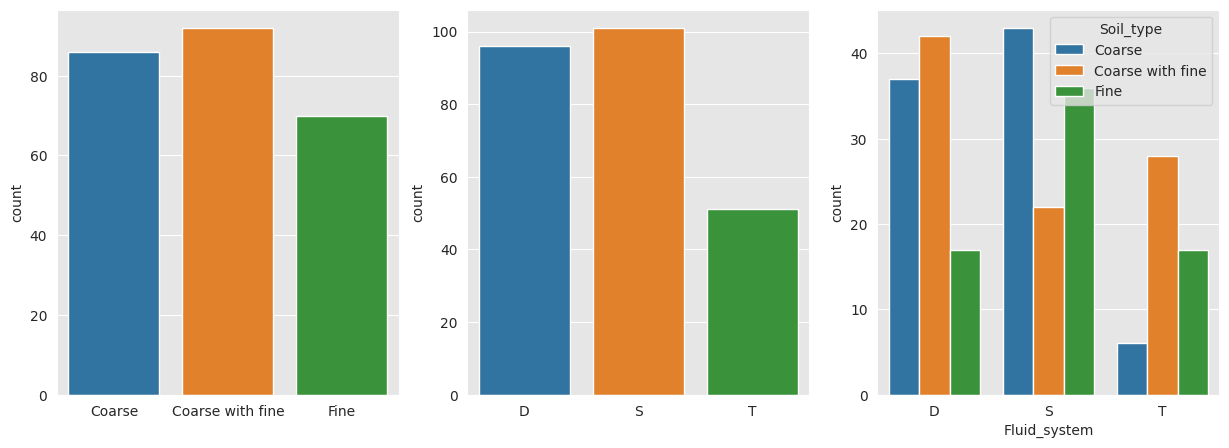

In [10]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
plot_features(data, ['Soil_type', 'Fluid_system'], categorical = True)

GoodnessOfFitResult(fit_result=  params: FitParams(loc=12.274193548387096, scale=8.319859378363775)
 success: True
 message: 'The fit was performed successfully.', statistic=7.8093348296751515, pvalue=0.0001, null_distribution=array([0.42604962, 0.11473184, 0.18507574, ..., 0.23728585, 0.4009623 ,
       0.28938425]))

GoodnessOfFitResult(fit_result=  params: FitParams(loc=0.9847580645161289, scale=0.23316329774748348)
 success: True
 message: 'The fit was performed successfully.', statistic=39.18505462320962, pvalue=0.0001, null_distribution=array([0.50805112, 0.18431807, 0.33746083, ..., 0.41804637, 0.24523924,
       0.28919991]))

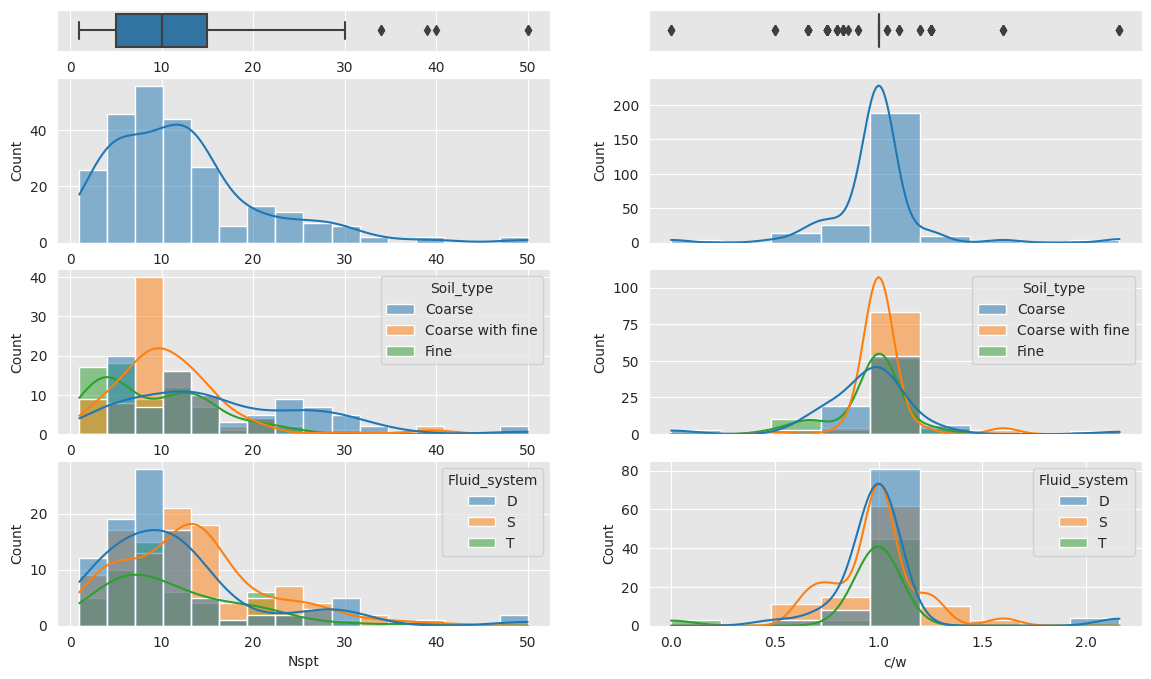

In [11]:
plot_features(data, ['Nspt', 'c/w'])
display(stats.goodness_of_fit(stats.norm, data['Nspt']))
display(stats.goodness_of_fit(stats.norm, data['c/w']))

Distribution of $N_{SPT}$ can be described by the log norm function. While for variable $c/w$ data are concetrated around value of 1.0, which at first look like normal distribution. Looking at the p-value for both variables none of them can be classified as normal distributed.

Now, let's concentrated on the grout density and viscosity.

GoodnessOfFitResult(fit_result=  params: FitParams(loc=1489.6290322580646, scale=88.29500311324638)
 success: True
 message: 'The fit was performed successfully.', statistic=39.698326335247145, pvalue=0.0001, null_distribution=array([0.21362378, 0.23311411, 0.13276009, ..., 0.22609256, 0.36983193,
       0.34478551]))

GoodnessOfFitResult(fit_result=  params: FitParams(loc=10.506451612903225, scale=10.144735911308869)
 success: True
 message: 'The fit was performed successfully.', statistic=55.5126361231039, pvalue=0.0001, null_distribution=array([0.66287051, 0.80441221, 0.29014749, ..., 0.75882243, 0.5378594 ,
       0.38920894]))

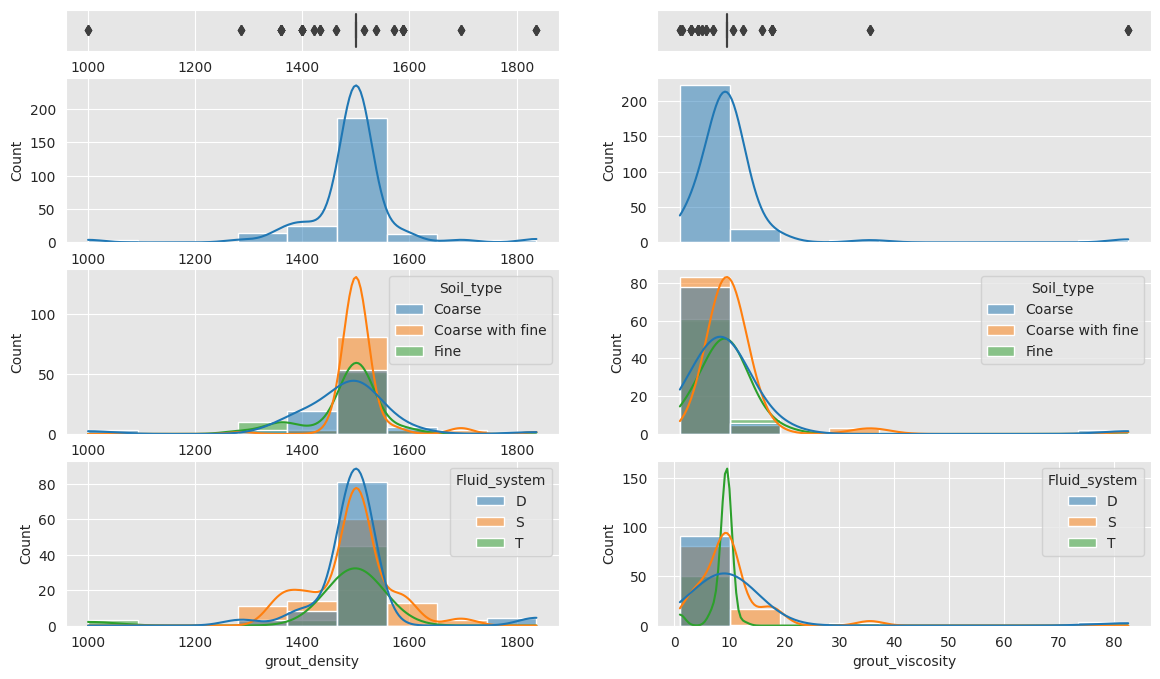

In [12]:
plot_features(data, ['grout_density', 'grout_viscosity'])
display(stats.goodness_of_fit(stats.norm, data['grout_density']))
display(stats.goodness_of_fit(stats.norm, data['grout_viscosity']))

From the above plots and results from goodness of fit, it is clear that none of those variables fall into normal distribution.

Let's continue and see distribution of energy and columns diameter.

GoodnessOfFitResult(fit_result=  params: FitParams(loc=44.94689516129032, scale=64.28490662570495)
 success: True
 message: 'The fit was performed successfully.', statistic=30.416831039619183, pvalue=0.0001, null_distribution=array([0.40687303, 0.36803971, 0.23027848, ..., 0.56362363, 0.40298583,
       0.30293825]))

GoodnessOfFitResult(fit_result=  params: FitParams(loc=1.483790322580645, scale=0.7911263612218584)
 success: True
 message: 'The fit was performed successfully.', statistic=4.882509784395012, pvalue=0.0001, null_distribution=array([0.29412965, 0.23226331, 0.29065116, ..., 0.47323951, 0.19356968,
       0.30802192]))

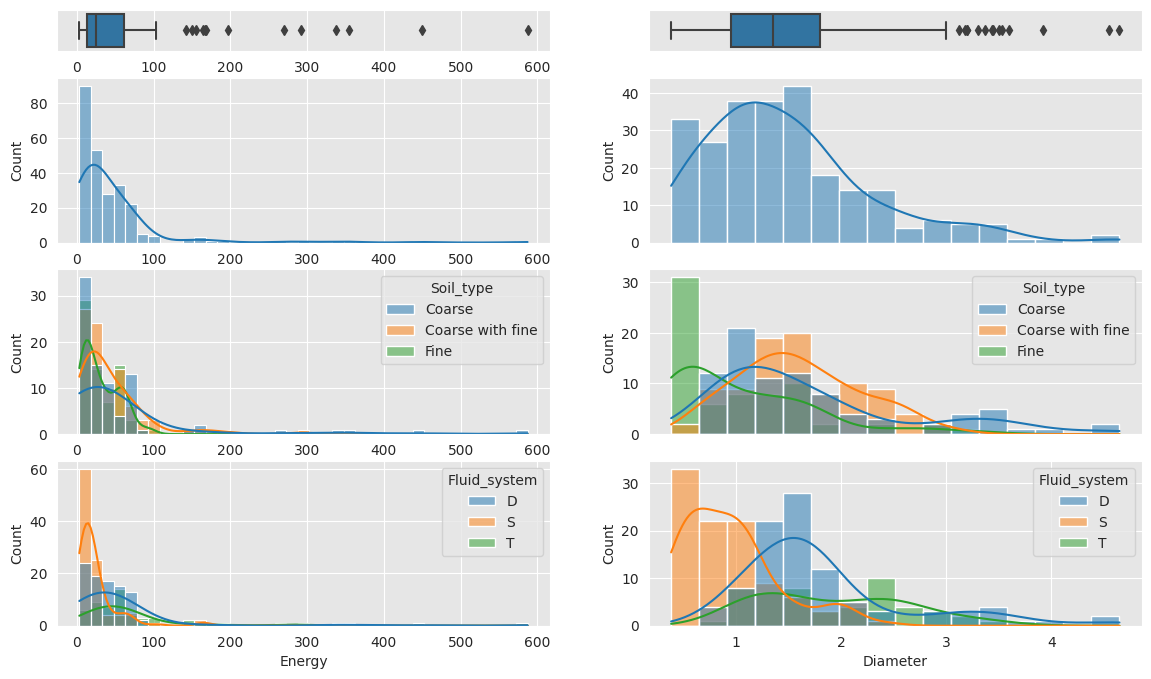

In [13]:
plot_features(data, ['Energy', 'Diameter'])
display(stats.goodness_of_fit(stats.norm, data['Energy']))
display(stats.goodness_of_fit(stats.norm, data['Diameter']))

Distribution of energy clearly can be described as log normal, while diameter is rather characterize by one between normal and log-normal.
None of the above variables is classified as normal by goodness of fit test.

### Transformation to Gaussian distribution <a class="anchor" id="section_2_2_2"></a>

It is often desirable to transform each variable to have a standard probability distribution, such as a Gaussian (normal) distribution or a uniform distribution. In this analysis chosen variables have been transformed to normaly distributed using Quantile tranformation.

Due to the perviously presented characteristics of variables only $N_{SPT}$, Energy and Diameter will be transformed into normally distributed.

After transformation into normal distribution, median value is equal to 0, while data range from negative to positive. To improve performace of ML model further scaling data to 0-1 scale has been carried out.

GoodnessOfFitResult(fit_result=  params: FitParams(loc=0.5003816895516476, scale=0.10999710672776804)
 success: True
 message: 'The fit was performed successfully.', statistic=2.894295866972982, pvalue=0.0001, null_distribution=array([0.33310291, 0.65581656, 0.39728847, ..., 0.38289276, 0.24584387,
       0.18225833]))

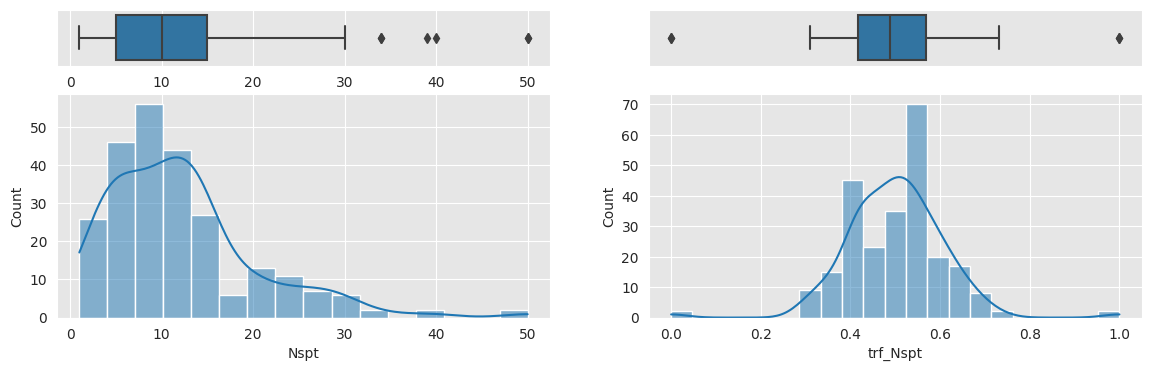

In [14]:
data['trf_Nspt'] = transform(data, 'Nspt', 'quantile')
display(stats.goodness_of_fit(stats.norm, data['trf_Nspt']))

plot_features(data, ['Nspt', 'trf_Nspt'], hue=False)

GoodnessOfFitResult(fit_result=  params: FitParams(loc=0.5000215601498142, scale=0.10426910003405881)
 success: True
 message: 'The fit was performed successfully.', statistic=0.4123790049223146, pvalue=0.343, null_distribution=array([0.3272441 , 0.57197517, 0.34401185, ..., 0.34656275, 0.7078744 ,
       0.24712492]))

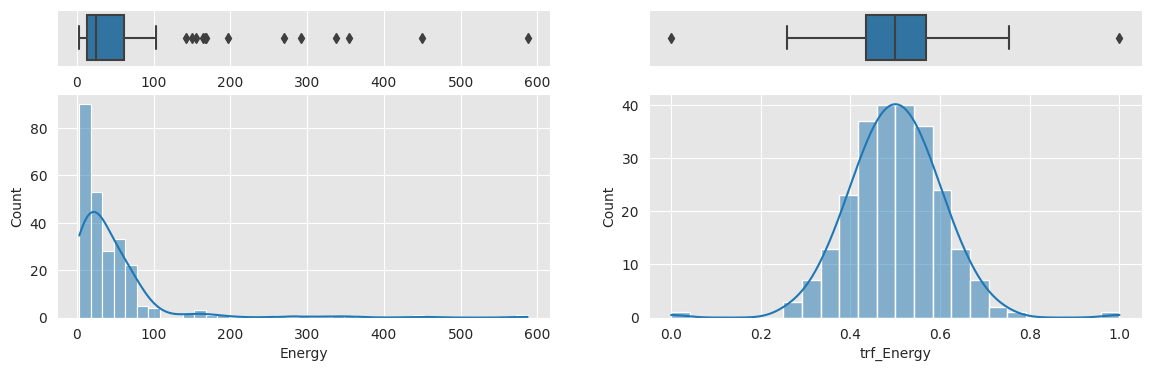

In [15]:
data['trf_Energy'] = transform(data, 'Energy', 'quantile')
display(stats.goodness_of_fit(stats.norm, data['trf_Energy']))

plot_features(data, ['Energy', 'trf_Energy'], hue=False)

GoodnessOfFitResult(fit_result=  params: FitParams(loc=0.4990537281326445, scale=0.1077121511096239)
 success: True
 message: 'The fit was performed successfully.', statistic=0.9054929932574964, pvalue=0.0194, null_distribution=array([0.30911555, 0.16946528, 0.32595097, ..., 0.40995815, 0.67860073,
       0.28910966]))

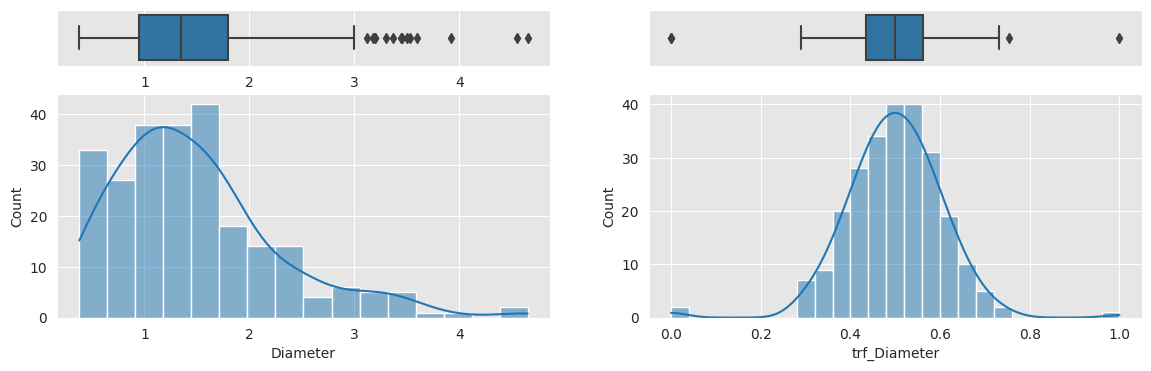

In [16]:
data_np = np.array(data['Diameter']).reshape(-1, 1)
scaler_1 = QuantileTransformer(output_distribution='normal', n_quantiles=len(data_np)).fit(data_np)
data_tr = scaler_1.transform(data_np)

scaler_2 = MinMaxScaler().fit(data_tr)
data_tr = scaler_2.transform(data_tr)

df = pd.DataFrame(data_tr)
df.rename(columns={0: f'trf_Diameter'}, inplace=True)
data['trf_Diameter'] = df.copy()

display(stats.goodness_of_fit(stats.norm, data['trf_Diameter']))
plot_features(data, ['Diameter', 'trf_Diameter'], hue=False)

To summarize above transformations, acc. to the goodness of fit test only two features named: Energy and Diameter after transformation follow Gaussian distribution. However, looking at the shape of $N_{SPT}$ distribution, one can state that it's almost normal. Additionally, from the experience it is known that $N_{SPT}$ should also follow Gaussian distribution thus this transformaiton can be acceptable.

### Treating categorical data <a class="anchor" id="section_2_2_3"></a>
One-hot encoding encoding has been used to transform categorical data, i.e. 'Soil_type' and 'Fluid_system' into binary ones.

In [17]:
# One-hot encoded for 'Soil_type' and 'Fluid_system' features and convert to dummy variabel encoding
soil_type_one_hot = pd.get_dummies(data['Soil_type'])
fluid_system_one_hot = pd.get_dummies(data['Fluid_system'])

# Merge dummy variable encoded categories with former DataFrame
data = pd.concat([data, soil_type_one_hot], axis=1)
data = pd.concat([data, fluid_system_one_hot], axis=1)

### Treating missing data (imputation) <a class="anchor" id="section_2_2_4"></a>
Missing data can significantly reduce usability of the database thus detecing and treating them correctly is required. From the code below it can be seen that there are no missing data thus no futher action is needed.

In [128]:
# Detect missing data
data.isna().sum()

Soil_type           0
Nspt                0
Fluid_system        0
c/w                 0
grout_density       0
grout_viscosity     0
Energy              0
Diameter            0
trf_Nspt            0
trf_Energy          0
trf_Diameter        0
Coarse              0
Coarse with fine    0
Fine                0
D                   0
S                   0
T                   0
dtype: int64

### Treating outliers <a class="anchor" id="section_2_2_5"></a>
The outliers are identified using IQR method and then are winsorized.

It is possible that knowledge of whether a row contains a missing value or not or if value has been manipulated by winsorizing will be useful to the model when making a prediction. One approach to exposing the model to this knowledge is by providing an additional column that is a binary flag indicating whether the row had a missing/modified value or not.
    0: Row does not contain a missing value.
    1: Row contains a missing value (which was/will be imputed).

In [19]:
ids_energy = outliers(data, 'trf_Energy', 'IQR', 'winsorize')
ids_diameter = outliers(data, 'trf_Diameter', 'IQR', 'winsorize')
ids_nspt = outliers(data, 'trf_Nspt', 'IQR', 'winsorize')

# binary_flag(data, ids_energy, 'trf_Energy', 'out')
# binary_flag(data, ids_diameter, 'trf_Diameter', 'out')
# binary_flag(data, ids_nspt, 'trf_Nspt', 'out')

## Multivariate analysis <a class="anchor" id="section_2_3"></a>
### Features correlation heatmap  <a class="anchor" id="section_2_3_1"></a>
To analyze the relationships between multiple variables simultaneously a multivariate analysis is performed. Heatmap of correlations has beeen adopted to visialize relationships between variables. The heatmap shows the correlation coefficients between each pair of variables in a matrix form, with colors indicating the strength and direction of the correlation. A value of correlation equal to 1 means that two variables have a perfect positive correlation and opposite, value equal to 0 indicates no relation at all. 

Firstly, all variables have been plotted on heatmap.

<AxesSubplot: >

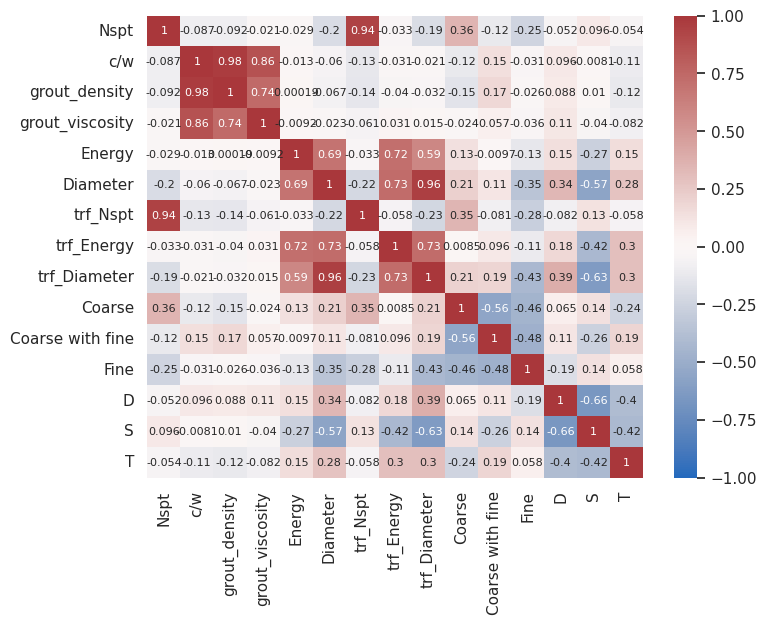

In [20]:
# Plot correlation heatmap for all features
features = ['c/w', 'grout_density', 'grout_viscosity', 'trf_Energy', 'trf_Diameter', 'trf_Nspt', 'S', 'D', 'T', 'Coarse', 'Coarse with fine', 'Fine']
sns.set(rc={'figure.figsize': (8, 6)})
sns.heatmap(data.corr(), vmin=-1, vmax=1, cmap='vlag', annot=True, annot_kws={'fontsize': 8},)

From the above heatmap it can be easily noticed that features $c/w$, 'grout_density' and 'grout_viscosity' are not correlate (correlation factor of -0.06, -0.067 and -0.023, respectively) with the target feature, i.e. 'Diameter'. For this reason they can be removed from the dataset together with their transformed distributions, i.e. with 'trf_' prefix.

Furthermore, features 'S', 'D' and 'T' indicates fluid system with one-hot encoding and thus are interrelated. Similarly features 'Fine', 'Coarse with fine' and 'Coarse' represents soil type and also are interrelated.

The cleaned up heatmap of features correlations is given below.

<AxesSubplot: >

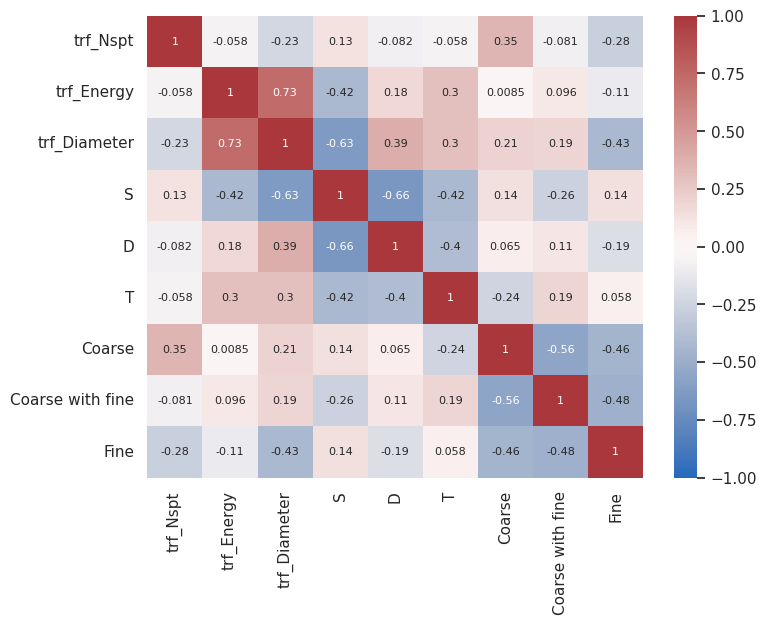

In [21]:
# Plot cleaned correlation heatmap
features = ['trf_Nspt', 'trf_Energy', 'trf_Diameter', 'S', 'D', 'T', 'Coarse', 'Coarse with fine', 'Fine']
sns.heatmap(data[features].corr(), vmin=-1, vmax=1, cmap='vlag', annot=True, annot_kws={'fontsize': 8},)

### Correlation of Energy and $N_{SPT}$ to Diameter  <a class="anchor" id="section_2_3_2"></a>
The next step is to create linear regression plots of correlated variables, i.e. for Energy, $N_{SPT}$ and Diameter. 

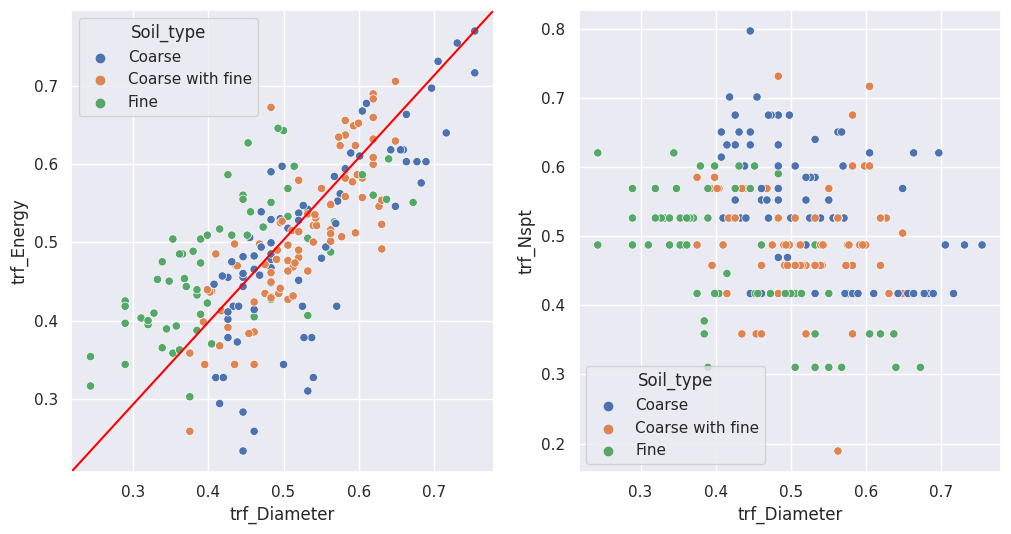

In [129]:
sns.set(style='darkgrid')
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(12, 6))
g1 = sns.scatterplot(ax=axes[0], x=data['trf_Diameter'], y=data['trf_Energy'], data=data, hue="Soil_type")
g2 = sns.scatterplot(ax=axes[1], x=data['trf_Diameter'], y=data['trf_Nspt'], data=data, hue="Soil_type")

line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = axes[0].transAxes
line.set_transform(transform)
axes[0].add_line(line)

In [23]:
display(data[(data['Coarse'] == 1)][['trf_Nspt', 'trf_Diameter']].corr())

,trf_Nspt,trf_Diameter
trf_Nspt,1.000000,-0.464687
trf_Diameter,-0.464687,1.000000


In [24]:
display(data[(data['Coarse with fine'] == 1)][['trf_Nspt', 'trf_Diameter']].corr())

,trf_Nspt,trf_Diameter
trf_Nspt,1.000000,-0.043651
trf_Diameter,-0.043651,1.000000


In [25]:
display(data[(data['Fine'] == 1)][['trf_Nspt', 'trf_Diameter']].corr())

,trf_Nspt,trf_Diameter
trf_Nspt,1.000000,-0.668391
trf_Diameter,-0.668391,1.000000


# Machine learning predictive model
In this section ML model is defined, trained and it's performance is checked against the testing set.

## Data preparation for ML
Due to the redundancy created by one-hot encoding, i.e. by the fact that for each category new column is created and data are binary coded, one columne is unecessary. The one-hot encoding is transfered to dummy variable encoding by removing one chosen column. In the analysed case one-hot encoded column for triple fluid 'T' and for 'Fine' soil type were dropped.

Furthermore, as a result of multivariate analysis, variables with very small correlation ( 'grout density', 'grout viscosity', 'c/w') to target 'diameter' have been also droped.

In [26]:
# Created DataFrame with a selected features (correlated with diameter)
data_ml = data.drop(columns=['grout_density', 'grout_viscosity', 'c/w', 'Fine', 'T', 'Nspt'])

In [27]:
display(data_ml)

,Soil_type,Fluid_system,Energy,Diameter,trf_Nspt,trf_Energy,trf_Diameter,Coarse,Coarse with fine,D,S
0,Coarse,T,44.55,3.00,0.568903,0.546112,0.648931,1,0,0,0
1,Coarse with fine,T,44.55,2.60,0.526182,0.546112,0.627112,0,1,0,0
2,Fine,T,51.14,3.30,0.310338,0.551103,0.672485,0,0,0,0
3,Fine,T,51.14,1.20,0.590216,0.551103,0.483326,0,0,0,0
4,Coarse with fine,T,62.43,2.30,0.716613,0.582194,0.604910,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
243,Fine,S,11.20,0.44,0.526182,0.409784,0.327515,0,0,0,1
244,Fine,S,12.20,0.40,0.526182,0.425293,0.289151,0,0,0,1
245,Fine,S,20.30,0.47,0.526182,0.475334,0.338520,0,0,0,1
246,Fine,S,11.70,0.40,0.526182,0.418507,0.289151,0,0,0,1


## Model definition

Machine learning model is defined in this section starting from definition of callback (functions called during training of NN) and hyperparameters. To treat overfitting issue early stopping has been adopeted with restoring best weights. Training of neural network has been performed for 500 epochs usgin loss of mean absolute percentage error.

In [28]:
# Define callbacks used during training
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

callbacks_list = [early_stopping_callback]

In [29]:
# Define hyperparameters
hparams = {
    'EPOCHS': 500,
    'LOSS': 'mean_absolute_percentage_error',
    'LR': 1e-5,
    'OPTIMIZER': 'Adam',
    'BATCH_SIZE': 100
    }

Due to the fact that database is very small, i.e. it consist only 248 entries, learning process is susceptible to errors during the train/test split. To overcome this issue, repeated K-fold cross-validation has been performed to assess model performance. Additionally, due to the limited number of input variables and only one target, the model architecture is intentionally kept simple with 3 hidden layers consisting of 40, 20 and 10 neurons with ReLU activation functions. This simplicity is sufficient to describe the analyzed phenomena, and further increase of the model complexity does not results in improved accuracy. The TensorFlow model has been created using subclassing approach.

To address the issue of overfitting a 'BatchNormalization' layer between the input layer and the first hidden layer was introduced.

In [103]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()

        self.d_inp = tf.keras.layers.Dense(units=6, input_shape=[6])
        self.norm = tf.keras.layers.BatchNormalization()
        self.d_1 = tf.keras.layers.Dense(40, activation='relu')
        self.d_1 = tf.keras.layers.Dense(20, activation='relu')
        self.d_2 = tf.keras.layers.Dense(10, activation='relu')
        self.d_out = tf.keras.layers.Dense(1)

    def call(self, x):
        x = self.d_inp(x)
        x = self.norm(x)
        x = self.d_1(x)
        x = self.d_2(x)

        return self.d_out(x)

In [104]:
kfold = RepeatedKFold(n_splits=5, n_repeats=5)

metrics = []

for train, test in kfold.split(data_ml):
    
    # Clear session
    tf.keras.backend.clear_session()

    # Prepare data for training
    X_train = data_ml.iloc[train].drop(columns=['trf_Diameter', 'Diameter']).to_numpy()
    y_train = data_ml.iloc[train][['trf_Diameter', 'Diameter']].to_numpy()

    # Prepare data for testing
    X_test = data_ml.iloc[test].drop(columns=['trf_Diameter', 'Diameter']).to_numpy()
    y_test = data_ml.iloc[test][['trf_Diameter', 'Diameter']].to_numpy()
    
    # Define model
    model = MyModel()
    init_weights = model.get_weights()

    # Initialize the optimizer
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)

    # Compile and train model
    model.compile(optimizer = hparams.get('OPTIMIZER'),
                loss = hparams.get('LOSS'),
                metrics=['accuracy']
                )

    history = model.fit(X_train[:,3:].astype(float), y_train[:,0],
            validation_data=(X_test[:,3:].astype(float), y_test[:,0]),
            epochs=hparams.get('EPOCHS'),
            callbacks=callbacks_list,
            batch_size=hparams.get('BATCH_SIZE'),
            verbose=0
            )

    # Prediciton with inversed transformations and scalers
    y_pred = model.predict(X_test[:,3:].astype(float))
    y_pred = scaler_2.inverse_transform(y_pred)
    y_pred = scaler_1.inverse_transform(y_pred)

    df = pd.DataFrame({'Energy': X_test[:, 2], 'Diameter': y_test[:,1], 'Diameter_pred': np.transpose(y_pred)[0]})

    # Calculate metrics
    r2 = r2_score(df['Diameter'], df['Diameter_pred'])
    mse = mean_squared_error(df['Diameter'], df['Diameter_pred'])
    mape = mean_absolute_percentage_error(df['Diameter'], df['Diameter_pred'])*100

    metrics.append([mape, r2, mse])

    display(f'R\u00b2 = {r2:.3f}, MSE = {mse:.3f}, MAPE = {mape:.3f}')


2/2 [==============================] - 0s 3ms/step


'R² = 0.817, MSE = 0.055, MAPE = 11.886'

2/2 [==============================] - 0s 2ms/step


'R² = 0.725, MSE = 0.190, MAPE = 17.856'

2/2 [==============================] - 0s 2ms/step


'R² = 0.890, MSE = 0.088, MAPE = 12.172'

2/2 [==============================] - 0s 2ms/step


'R² = 0.891, MSE = 0.049, MAPE = 14.280'

2/2 [==============================] - 0s 2ms/step


'R² = 0.822, MSE = 0.136, MAPE = 15.255'

2/2 [==============================] - 0s 2ms/step


'R² = 0.874, MSE = 0.050, MAPE = 12.484'

2/2 [==============================] - 0s 2ms/step


'R² = 0.862, MSE = 0.091, MAPE = 11.432'

2/2 [==============================] - 0s 2ms/step


'R² = 0.782, MSE = 0.156, MAPE = 15.419'

2/2 [==============================] - 0s 2ms/step


'R² = 0.829, MSE = 0.093, MAPE = 16.059'

2/2 [==============================] - 0s 3ms/step


'R² = 0.852, MSE = 0.115, MAPE = 12.192'

2/2 [==============================] - 0s 3ms/step


'R² = 0.798, MSE = 0.163, MAPE = 16.260'

2/2 [==============================] - 0s 2ms/step


'R² = 0.743, MSE = 0.079, MAPE = 15.429'

2/2 [==============================] - 0s 2ms/step


'R² = 0.828, MSE = 0.148, MAPE = 12.862'

2/2 [==============================] - 0s 2ms/step


'R² = 0.858, MSE = 0.077, MAPE = 10.902'

2/2 [==============================] - 0s 2ms/step


'R² = 0.816, MSE = 0.095, MAPE = 14.714'

2/2 [==============================] - 0s 2ms/step


'R² = 0.809, MSE = 0.135, MAPE = 14.614'

2/2 [==============================] - 0s 2ms/step


'R² = 0.568, MSE = 0.184, MAPE = 14.678'

2/2 [==============================] - 0s 2ms/step


'R² = 0.898, MSE = 0.046, MAPE = 13.347'

2/2 [==============================] - 0s 3ms/step


'R² = 0.906, MSE = 0.068, MAPE = 11.715'

2/2 [==============================] - 0s 2ms/step


'R² = 0.819, MSE = 0.148, MAPE = 17.050'

2/2 [==============================] - 0s 2ms/step


'R² = 0.782, MSE = 0.156, MAPE = 12.579'

2/2 [==============================] - 0s 2ms/step


'R² = 0.900, MSE = 0.074, MAPE = 12.429'

2/2 [==============================] - 0s 2ms/step


'R² = 0.700, MSE = 0.120, MAPE = 14.389'

2/2 [==============================] - 0s 2ms/step


'R² = 0.862, MSE = 0.084, MAPE = 13.692'

2/2 [==============================] - 0s 2ms/step


'R² = 0.814, MSE = 0.113, MAPE = 13.393'

From the repeated K-fold cross-validation of the proposed model the distribution of $MAPE$, $MSE$ and $R^2$ is given below. It can be seen that representative (median) $MAPE$ is equal to $13.7$ which is similar to that from the one proposed by Ochmański et al. (2015). Please keep in mind that former study was done on a significantly smaller database (131 vs 248 entries). 

In [105]:
metrics = pd.DataFrame(metrics)
metrics.rename(columns={0: 'MAPE', 1: 'R', 2: 'MSE'}, inplace=True)

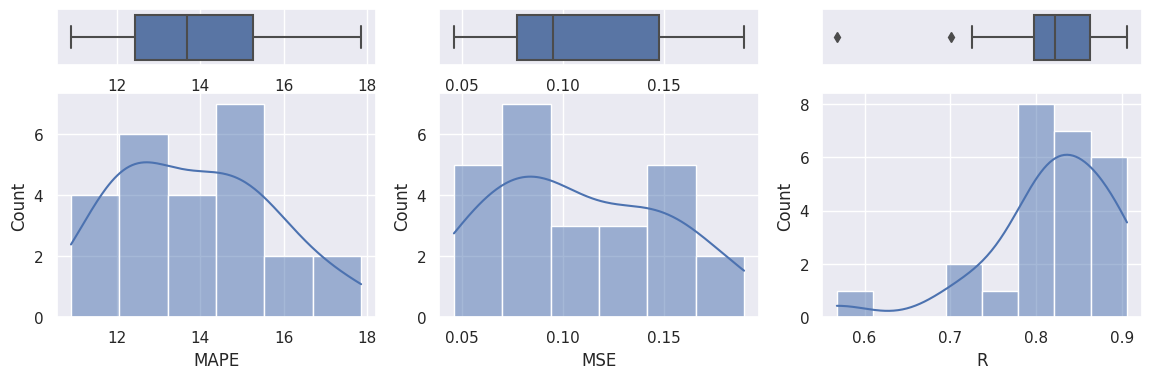

In [106]:
plot_features(metrics, ['MAPE', 'MSE', 'R'], hue=False)

Finally, to prove that issue of overfitting has been eliminated, plot of training and validation loss has been presented below for all epochs and zoomed view for last 200 epochs.

(4.0, 8.0)

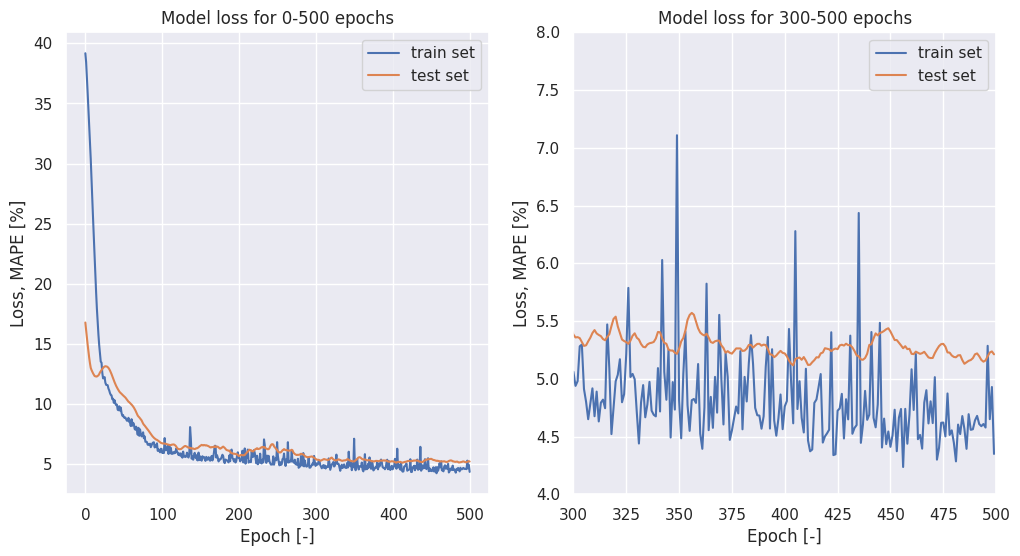

In [157]:
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(12, 6))

axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].title.set_text('Model loss for 0-500 epochs')
axes[0].set_ylabel('Loss, MAPE [%]')
axes[0].set_xlabel('Epoch [-]')
axes[0].legend(['train set', 'test set'], loc='upper right')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].title.set_text('Model loss for 300-500 epochs')
axes[1].set_ylabel('Loss, MAPE [%]')
axes[1].set_xlabel('Epoch [-]')
axes[1].legend(['train set', 'test set'], loc='upper right')
axes[1].set_xlim([300, 500])
axes[1].set_ylim([4, 8])

## Prediction
In this section trained ML model is used to predict diameters of columns from testing set. Predicted values are plotted agains real values. It can be seen that for all testing data $R^2 = 0.858$ and $MAPE=13.64\%$, i.e. for all columns despite used fluid system. Calculating $R^2$ separately for single, double and triple fluid system result in $0.91$, $0.75$ and $0.45$, while $MAPE$ is equal to $11.34$, $14.24$ and $19.45\%$.

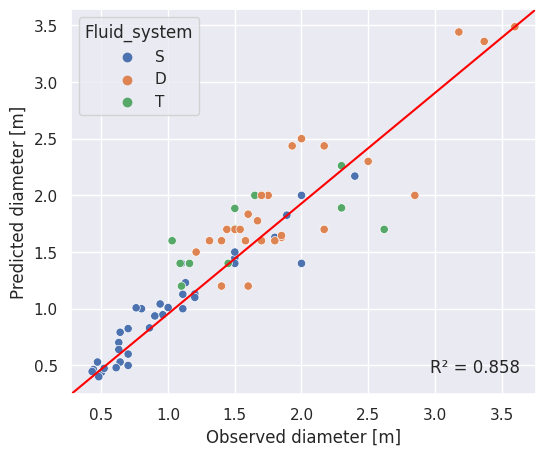

In [164]:
df = pd.DataFrame({
    'Energy': X_test[:, 2],
    'Soil_type': X_test[:, 0],
    'Fluid_system': X_test[:, 1],
    'Nspt': X_test[:,3],
    'Diameter': y_test[:,1],
    'Diameter_pred': np.transpose(y_pred)[0]
    })

x_min = min([df['Diameter_pred'].min(), df['Diameter'].min()])
x_max = max([df['Diameter_pred'].max(), df['Diameter'].max()])

r2 = r2_score(df['Diameter'], df['Diameter_pred'])

axis = plt.subplot()
sns.set(rc={'figure.figsize': (6, 5)})
sns.set(style='darkgrid')
sns.scatterplot(x=df['Diameter'], y=df['Diameter_pred'], hue='Fluid_system', data=df)
plt.ylabel('Predicted diameter [m]')
plt.xlabel('Observed diameter [m]')
plt.annotate(f"R\u00b2 = {r2:.3f}", (x_max-(x_max-x_min)*0.2, 1.1*x_min))

line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = axis.transAxes
line.set_transform(transform)
axis.add_line(line)

In [130]:
r2_S = r2_score(df[df['Fluid_system'] == "S"]["Diameter"], df[df['Fluid_system'] == "S"]["Diameter_pred"])
r2_D = r2_score(df[df['Fluid_system'] == "D"]["Diameter"], df[df['Fluid_system'] == "D"]["Diameter_pred"])
r2_T = r2_score(df[df['Fluid_system'] == "T"]["Diameter"], df[df['Fluid_system'] == "T"]["Diameter_pred"])

MAPE = mean_absolute_percentage_error(df["Diameter"], df["Diameter_pred"])*100
MAPE_S = mean_absolute_percentage_error(df[df['Fluid_system'] == "S"]["Diameter"], df[df['Fluid_system'] == "S"]["Diameter_pred"])*100
MAPE_D = mean_absolute_percentage_error(df[df['Fluid_system'] == "D"]["Diameter"], df[df['Fluid_system'] == "D"]["Diameter_pred"])*100
MAPE_T = mean_absolute_percentage_error(df[df['Fluid_system'] == "T"]["Diameter"], df[df['Fluid_system'] == "T"]["Diameter_pred"])*100

print(f"R\u00b2 for all columns is equal to {r2:.2f}, while MAPE to {MAPE:.2f}")
print(f"R\u00b2 for columns created using single fluid is equal to {r2_S:.2f}, while MAPE to {MAPE_S:.2f}")
print(f"R\u00b2 for columns created using double fluid is equal to {r2_D:.2f}, while MAPE to {MAPE_D:.2f}")
print(f"R\u00b2 for columns created using triple fluid is equal to {r2_T:.2f}, while MAPE to {MAPE_T:.2f}")

R² for all columns is equal to 0.86, while MAPE to 13.64
R² for columns created using single fluid is equal to 0.91, while MAPE to 11.34
R² for columns created using double fluid is equal to 0.75, while MAPE to 14.24
R² for columns created using triple fluid is equal to 0.47, while MAPE to 19.45


## Further investigation of the data
From the above plot it can be seen that prediction is satisfactory for relatively small columns $(D < 1.0)$ created with single fluid system (S).
For double and triple fluid system (D and T) scatter is high and unacceptable. Thus preventive measures should be used for the improvement of predictive capablity. Overall $R^2$ is equal to 0.91.
Further study concentrates on design charts, i.e. plots of energy in logaritmic scale vs column diameter for specific soil type and value of $N_{SPT}$. Below you can see such plots separate for single, double and triple fluid system. 

[(1.0, 400.0),
 (0.0, 4.0),
 None,
 Text(0.5, 0, 'Energy [MJ/m]'),
 Text(0, 0.5, 'Diameter [m]'),
 Text(0.5, 1.0, 'Triple fluid')]

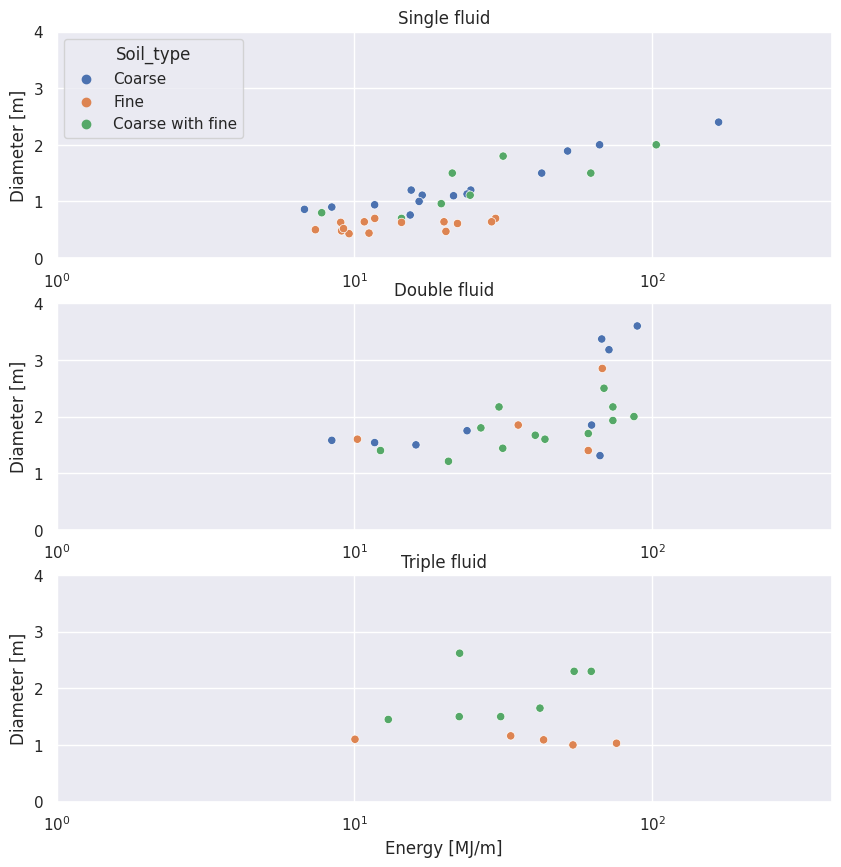

In [153]:
# Plotting Diameter vs Energy in log scale for all fluid system
unique = df["Soil_type"].unique()
palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))

fig, axes = plt.subplots(3, 1, sharex=False, figsize=(10, 10))
g1 = sns.scatterplot(ax=axes[0], x=df['Energy'], y=df['Diameter'], hue="Soil_type", data=df[df["Fluid_system"]=="S"], palette=palette)
g2 = sns.scatterplot(ax=axes[1], x=df['Energy'], y=df['Diameter'], hue="Soil_type", data=df[df["Fluid_system"]=="D"], palette=palette, legend = False)
g3 = sns.scatterplot(ax=axes[2], x=df['Energy'], y=df['Diameter'], hue="Soil_type", data=df[df["Fluid_system"]=="T"], palette=palette, legend = False)
g1.set(xlim=(1,400), ylim=(0, 4), xscale="log", xlabel='', ylabel='Diameter [m]', title='Single fluid')
g2.set(xlim=(1,400), ylim=(0, 4), xscale="log", xlabel='', ylabel='Diameter [m]', title='Double fluid')
g3.set(xlim=(1,400), ylim=(0, 4), xscale="log", xlabel='Energy [MJ/m]', ylabel='Diameter [m]', title='Triple fluid')

# TODO

Due to the relatively low performance of the model which results from a poor data quality, i.e. several variables are hidden in 'Energy' parameter, there is a strict need to improve prediction. Possible way is to create ML model describing response of analytical model (Flora et al.) and using transfer learning technique, perform training on the presented here database. This may increase accuracy and eliminate limitation of analytical model by subjected ML model to new observations.